In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import SAC  # Changed back to SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# --- 1. Define the Rollout Callback ---
class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            # SEED: Fixed seed ensures we compare all algos on the same test case
            obs, _ = self.eval_env.reset(seed=123) 
            asv_history, glider_history = [], []
            done = False
            
            # For SAC, these remain None/True and don't affect the MlpPolicy
            lstm_states = None
            episode_starts = np.ones((1,), dtype=bool)

            while not done:
                action, _ = self.model.predict(
                    obs, 
                    state=lstm_states, 
                    episode_start=episode_starts, 
                    deterministic=True
                )
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
                glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                
                done = terminated or truncated

            asv_history, glider_history = np.array(asv_history), np.array(glider_history)
            
            plt.figure(figsize=(6, 6))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (SAC)", linewidth=2)
            plt.title(f"SAC Rollout at Step {self.n_calls}")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.legend()
            plt.grid(True)
            
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f">>> Saved SAC rollout to {save_path}")
        return True

# --- 2. Setup Directories and Environments ---
algo_name = "sac" 
base_path = f"./experiments/{algo_name}/"
os.makedirs(base_path, exist_ok=True)

# Main training environment
env = AsvGliderBearingEnv()
env = Monitor(env, os.path.join(base_path, "training_logs"))

# Evaluation environment (Wrapped with Monitor to fix the warning)
eval_env = AsvGliderBearingEnv()
eval_env = Monitor(eval_env, os.path.join(base_path, "eval_logs"))

# --- 3. Initialize SAC Model ---
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=7e-5, 
    gamma=0.99,
    buffer_size=1_000_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    device="cuda",
)

# --- 4. Callbacks ---
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path=os.path.join(base_path, "best_model"),
    log_path=os.path.join(base_path, "eval_results"), 
    eval_freq=5000,
    deterministic=True,
    render=False
)

plot_callback = TrajectoryPlotCallback(
    eval_env, 
    render_freq=10000, 
    log_dir=os.path.join(base_path, "rollouts")
)

callbacks = CallbackList([eval_callback, plot_callback])

# --- 5. Train ---
try:
    print(f"Starting training for {algo_name}...")
    model.learn(
        total_timesteps=100_000, 
        callback=callbacks,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\nTraining interrupted.")
finally:
    env.close()
    eval_env.close()
    model.save(os.path.join(base_path, f"{algo_name}_final_model"))
    print("Environment closed and SAC model saved.")

2026-01-12 23:58:15.331919: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 23:58:15.342444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768258695.353888  125631 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768258695.357378  125631 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768258695.366087  125631 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

Starting training for sac...


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.33e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 5456      |
|    time_elapsed    | 0         |
|    total_timesteps | 4000      |
----------------------------------


Eval num_timesteps=5000, episode_reward=-1689.62 +/- 241.26

Episode length: 1000.00 +/- 0.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 1e+03     |
|    mean_reward     | -1.69e+03 |
| time/              |           |
|    total_timesteps | 5000      |
----------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -777     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2046     |
|    time_elapsed    | 3        |
|    total_timesteps | 8000     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-1053.25 +/- 877.37

Episode length: 1000.00 +/- 0.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 1e+03     |
|    mean_reward     | -1.05e+03 |
| time/              |           |
|    total_timesteps | 10000     |
----------------------------------


New best mean reward!

>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -579     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 646      |
|    time_elapsed    | 18       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -17.3    |
|    critic_loss     | 0.938    |
|    ent_coef        | 0.881    |
|    ent_coef_loss   | -0.266   |
|    learning_rate   | 7e-05    |
|    n_updates       | 1999     |
---------------------------------


Eval num_timesteps=15000, episode_reward=2229.81 +/- 122.39

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.23e+03 |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | -47.5    |
|    critic_loss     | 1.13     |
|    ent_coef        | 0.722    |
|    ent_coef_loss   | -0.679   |
|    learning_rate   | 7e-05    |
|    n_updates       | 4999     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 109      |
| time/              |          |
|    episodes        | 16       |
|    fps             | 368      |
|    time_elapsed    | 43       |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | -56.6    |
|    critic_loss     | 0.83     |
|    ent_coef        | 0.675    |
|    ent_coef_loss   | -0.734   |
|    learning_rate   | 7e-05    |
|    n_updates       | 5999     |
---------------------------------


Eval num_timesteps=20000, episode_reward=2410.26 +/- 247.33

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.41e+03 |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -90.2    |
|    critic_loss     | 1.23     |
|    ent_coef        | 0.514    |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 7e-05    |
|    n_updates       | 9999     |
---------------------------------


New best mean reward!

>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 564      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 290      |
|    time_elapsed    | 68       |
|    total_timesteps | 20000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 888      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 261      |
|    time_elapsed    | 91       |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -120     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.395    |
|    ent_coef_loss   | -1.26    |
|    learning_rate   | 7e-05    |
|    n_updates       | 13999    |
---------------------------------


Eval num_timesteps=25000, episode_reward=2410.34 +/- 69.52

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.41e+03 |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -125     |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.37     |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 7e-05    |
|    n_updates       | 14999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.1e+03  |
| time/              |          |
|    episodes        | 28       |
|    fps             | 239      |
|    time_elapsed    | 117      |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | -144     |
|    critic_loss     | 1.84     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 7e-05    |
|    n_updates       | 17999    |
---------------------------------


Eval num_timesteps=30000, episode_reward=2512.30 +/- 155.31

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.51e+03 |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -155     |
|    critic_loss     | 1.86     |
|    ent_coef        | 0.266    |
|    ent_coef_loss   | -1.24    |
|    learning_rate   | 7e-05    |
|    n_updates       | 19999    |
---------------------------------


New best mean reward!

>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.26e+03 |
| time/              |          |
|    episodes        | 32       |
|    fps             | 223      |
|    time_elapsed    | 142      |
|    total_timesteps | 32000    |
| train/             |          |
|    actor_loss      | -162     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.234    |
|    ent_coef_loss   | -1.13    |
|    learning_rate   | 7e-05    |
|    n_updates       | 21999    |
---------------------------------


Eval num_timesteps=35000, episode_reward=2398.13 +/- 139.40

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.4e+03  |
| time/              |          |
|    total_timesteps | 35000    |
| train/             |          |
|    actor_loss      | -176     |
|    critic_loss     | 2.41     |
|    ent_coef        | 0.193    |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 7e-05    |
|    n_updates       | 24999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.39e+03 |
| time/              |          |
|    episodes        | 36       |
|    fps             | 212      |
|    time_elapsed    | 169      |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | -181     |
|    critic_loss     | 1.99     |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | -0.656   |
|    learning_rate   | 7e-05    |
|    n_updates       | 25999    |
---------------------------------


Eval num_timesteps=40000, episode_reward=2381.93 +/- 270.18

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.38e+03 |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -193     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.144    |
|    ent_coef_loss   | -0.872   |
|    learning_rate   | 7e-05    |
|    n_updates       | 29999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.48e+03 |
| time/              |          |
|    episodes        | 40       |
|    fps             | 204      |
|    time_elapsed    | 195      |
|    total_timesteps | 40000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.58e+03 |
| time/              |          |
|    episodes        | 44       |
|    fps             | 201      |
|    time_elapsed    | 218      |
|    total_timesteps | 44000    |
| train/             |          |
|    actor_loss      | -201     |
|    critic_loss     | 2.16     |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | -0.228   |
|    learning_rate   | 7e-05    |
|    n_updates       | 33999    |
---------------------------------


Eval num_timesteps=45000, episode_reward=2525.73 +/- 142.88

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.53e+03 |
| time/              |          |
|    total_timesteps | 45000    |
| train/             |          |
|    actor_loss      | -206     |
|    critic_loss     | 1.75     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | 0.0312   |
|    learning_rate   | 7e-05    |
|    n_updates       | 34999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.65e+03 |
| time/              |          |
|    episodes        | 48       |
|    fps             | 196      |
|    time_elapsed    | 244      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | -215     |
|    critic_loss     | 1.82     |
|    ent_coef        | 0.115    |
|    ent_coef_loss   | 0.0989   |
|    learning_rate   | 7e-05    |
|    n_updates       | 37999    |
---------------------------------


Eval num_timesteps=50000, episode_reward=2283.01 +/- 206.51

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.28e+03 |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -210     |
|    critic_loss     | 2.09     |
|    ent_coef        | 0.113    |
|    ent_coef_loss   | 0.175    |
|    learning_rate   | 7e-05    |
|    n_updates       | 39999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.7e+03  |
| time/              |          |
|    episodes        | 52       |
|    fps             | 192      |
|    time_elapsed    | 270      |
|    total_timesteps | 52000    |
| train/             |          |
|    actor_loss      | -215     |
|    critic_loss     | 2.03     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | -0.364   |
|    learning_rate   | 7e-05    |
|    n_updates       | 41999    |
---------------------------------


Eval num_timesteps=55000, episode_reward=2397.43 +/- 209.74

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.4e+03  |
| time/              |          |
|    total_timesteps | 55000    |
| train/             |          |
|    actor_loss      | -217     |
|    critic_loss     | 1.8      |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | -0.154   |
|    learning_rate   | 7e-05    |
|    n_updates       | 44999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.75e+03 |
| time/              |          |
|    episodes        | 56       |
|    fps             | 189      |
|    time_elapsed    | 295      |
|    total_timesteps | 56000    |
| train/             |          |
|    actor_loss      | -222     |
|    critic_loss     | 2.12     |
|    ent_coef        | 0.111    |
|    ent_coef_loss   | 0.272    |
|    learning_rate   | 7e-05    |
|    n_updates       | 45999    |
---------------------------------


Eval num_timesteps=60000, episode_reward=2431.02 +/- 352.12

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.43e+03 |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -223     |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.112    |
|    ent_coef_loss   | 0.333    |
|    learning_rate   | 7e-05    |
|    n_updates       | 49999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.78e+03 |
| time/              |          |
|    episodes        | 60       |
|    fps             | 186      |
|    time_elapsed    | 322      |
|    total_timesteps | 60000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.83e+03 |
| time/              |          |
|    episodes        | 64       |
|    fps             | 185      |
|    time_elapsed    | 345      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | -229     |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.294    |
|    learning_rate   | 7e-05    |
|    n_updates       | 53999    |
---------------------------------


Eval num_timesteps=65000, episode_reward=2652.80 +/- 295.73

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.65e+03 |
| time/              |          |
|    total_timesteps | 65000    |
| train/             |          |
|    actor_loss      | -230     |
|    critic_loss     | 1.66     |
|    ent_coef        | 0.123    |
|    ent_coef_loss   | -0.0362  |
|    learning_rate   | 7e-05    |
|    n_updates       | 54999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.86e+03 |
| time/              |          |
|    episodes        | 68       |
|    fps             | 183      |
|    time_elapsed    | 371      |
|    total_timesteps | 68000    |
| train/             |          |
|    actor_loss      | -225     |
|    critic_loss     | 1.73     |
|    ent_coef        | 0.118    |
|    ent_coef_loss   | -0.164   |
|    learning_rate   | 7e-05    |
|    n_updates       | 57999    |
---------------------------------


Eval num_timesteps=70000, episode_reward=2202.67 +/- 69.64

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.2e+03  |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 1.83     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -0.281   |
|    learning_rate   | 7e-05    |
|    n_updates       | 59999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.9e+03  |
| time/              |          |
|    episodes        | 72       |
|    fps             | 181      |
|    time_elapsed    | 397      |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | -221     |
|    critic_loss     | 1.85     |
|    ent_coef        | 0.113    |
|    ent_coef_loss   | -0.364   |
|    learning_rate   | 7e-05    |
|    n_updates       | 61999    |
---------------------------------


Eval num_timesteps=75000, episode_reward=2359.19 +/- 233.05

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.36e+03 |
| time/              |          |
|    total_timesteps | 75000    |
| train/             |          |
|    actor_loss      | -220     |
|    critic_loss     | 1.83     |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -0.231   |
|    learning_rate   | 7e-05    |
|    n_updates       | 64999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.94e+03 |
| time/              |          |
|    episodes        | 76       |
|    fps             | 179      |
|    time_elapsed    | 423      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | -223     |
|    critic_loss     | 1.9      |
|    ent_coef        | 0.114    |
|    ent_coef_loss   | -0.184   |
|    learning_rate   | 7e-05    |
|    n_updates       | 65999    |
---------------------------------


Eval num_timesteps=80000, episode_reward=2692.31 +/- 144.68

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.69e+03 |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -219     |
|    critic_loss     | 1.92     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | -0.0349  |
|    learning_rate   | 7e-05    |
|    n_updates       | 69999    |
---------------------------------


New best mean reward!

>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.95e+03 |
| time/              |          |
|    episodes        | 80       |
|    fps             | 177      |
|    time_elapsed    | 449      |
|    total_timesteps | 80000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.96e+03 |
| time/              |          |
|    episodes        | 84       |
|    fps             | 177      |
|    time_elapsed    | 473      |
|    total_timesteps | 84000    |
| train/             |          |
|    actor_loss      | -224     |
|    critic_loss     | 1.41     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | -0.205   |
|    learning_rate   | 7e-05    |
|    n_updates       | 73999    |
---------------------------------


Eval num_timesteps=85000, episode_reward=2485.52 +/- 180.75

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.49e+03 |
| time/              |          |
|    total_timesteps | 85000    |
| train/             |          |
|    actor_loss      | -226     |
|    critic_loss     | 1.55     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | 0.144    |
|    learning_rate   | 7e-05    |
|    n_updates       | 74999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.98e+03 |
| time/              |          |
|    episodes        | 88       |
|    fps             | 176      |
|    time_elapsed    | 499      |
|    total_timesteps | 88000    |
| train/             |          |
|    actor_loss      | -225     |
|    critic_loss     | 1.64     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | -0.0235  |
|    learning_rate   | 7e-05    |
|    n_updates       | 77999    |
---------------------------------


Eval num_timesteps=90000, episode_reward=2258.44 +/- 131.21

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.26e+03 |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -215     |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | -0.802   |
|    learning_rate   | 7e-05    |
|    n_updates       | 79999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2e+03    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 175      |
|    time_elapsed    | 525      |
|    total_timesteps | 92000    |
| train/             |          |
|    actor_loss      | -219     |
|    critic_loss     | 1.69     |
|    ent_coef        | 0.116    |
|    ent_coef_loss   | -0.00576 |
|    learning_rate   | 7e-05    |
|    n_updates       | 81999    |
---------------------------------


Eval num_timesteps=95000, episode_reward=2365.29 +/- 154.90

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.37e+03 |
| time/              |          |
|    total_timesteps | 95000    |
| train/             |          |
|    actor_loss      | -219     |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | -0.0963  |
|    learning_rate   | 7e-05    |
|    n_updates       | 84999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.03e+03 |
| time/              |          |
|    episodes        | 96       |
|    fps             | 174      |
|    time_elapsed    | 550      |
|    total_timesteps | 96000    |
| train/             |          |
|    actor_loss      | -225     |
|    critic_loss     | 1.34     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | 0.315    |
|    learning_rate   | 7e-05    |
|    n_updates       | 85999    |
---------------------------------


Eval num_timesteps=100000, episode_reward=2301.97 +/- 176.00

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.3e+03  |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -220     |
|    critic_loss     | 1.46     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | -0.0439  |
|    learning_rate   | 7e-05    |
|    n_updates       | 89999    |
---------------------------------


>>> Saved SAC rollout to ./experiments/sac/rollouts/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.05e+03 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 173      |
|    time_elapsed    | 577      |
|    total_timesteps | 100000   |
---------------------------------


Environment closed and SAC model saved.


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from stable_baselines3 import SAC
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.common.results_plotter import load_results, ts2xy
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# # --- 1. Define the Rollout Callback ---
# class TrajectoryPlotCallback(BaseCallback):
#     def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts_sac/"):
#         super().__init__()
#         self.eval_env = eval_env
#         self.render_freq = render_freq
#         self.log_dir = log_dir
#         os.makedirs(self.log_dir, exist_ok=True)

#     def _on_step(self) -> bool:
#         # Check if it's time to run a rollout
#         if self.n_calls % self.render_freq == 0:
#             obs, _ = self.eval_env.reset()
#             asv_history = []
#             glider_history = []
#             done = False
            
#             # Run one full test episode deterministically
#             while not done:
#                 action, _ = self.model.predict(obs, deterministic=True)
#                 obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
#                 # Store un-normalized positions for plotting
#                 asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
#                 glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
#                 done = terminated or truncated

#             # Convert to arrays for plotting
#             asv_history = np.array(asv_history)
#             glider_history = np.array(glider_history)

#             # Generate the trajectory plot
#             plt.figure(figsize=(6, 6))
#             plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
#             plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path", linewidth=2)
#             plt.scatter(asv_history[0, 0], asv_history[0, 1], c='blue', label="ASV Start")
#             plt.scatter(glider_history[0, 0], glider_history[0, 1], c='green', label="Glider Start")
            
#             plt.title(f"Rollout at Step {self.n_calls}")
#             plt.xlabel("X Position (m)")
#             plt.ylabel("Y Position (m)")
#             plt.legend()
#             plt.grid(True)
            
#             # Save the plot
#             save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
#             plt.savefig(save_path)
#             plt.close()
#             print(f">>> Saved trajectory rollout to {save_path}")

#         return True

# # --- 2. Setup Directories and Environments ---
# log_dir = "./sac_asv_logs_new/"
# os.makedirs(log_dir, exist_ok=True)

# # Main training environment
# env = AsvGliderBearingEnv()
# env = Monitor(env, log_dir)

# # Separate environment for the callback to use (prevents interference with training state)
# eval_env = AsvGliderBearingEnv()

# # --- 3. Initialize Model and Callback ---
# model = SAC(
#     "MlpPolicy", # Policy type
#     env,
#     verbose=1,
#     learning_rate=7e-5, 
#     gamma=0.99,
#     buffer_size=1_000_000,
#     learning_starts=10_000,
#     batch_size=256,
#     tau=0.005,
#     train_freq=1,
#     gradient_steps=1,
#     device="cuda",
# )

# # Initialize callback: plots every 10k steps
# plot_callback = TrajectoryPlotCallback(eval_env, render_freq=10000)

# from stable_baselines3.common.callbacks import CallbackList, EvalCallback

# # --- 4. Setup Evaluation & Real-time Printing ---
# # This environment is used to calculate the "mean reward" periodically
# eval_env = AsvGliderBearingEnv()
# eval_env = Monitor(eval_env, "./logs_sac/eval/") # Optional: logs eval results separately

# # 1. EvalCallback: This handles the mean reward printing you asked for
# eval_callback = EvalCallback(
#     eval_env, 
#     best_model_save_path="./logs_sac/best_model",
#     log_path="./logs_sac/results", 
#     eval_freq=5000,         # How often to calculate mean reward (every 5k steps)
#     deterministic=True, 
#     render=False
# )

# # 2. Combine with your trajectory plotter
# callbacks = CallbackList([eval_callback, plot_callback])

# # --- 5. Train with Error Handling ---
# try:
#     print("Starting training. Look for 'Eval num_timesteps' in the output for mean rewards.")
#     model.learn(
#         total_timesteps=100_000, 
#         callback=callbacks,
#         progress_bar=True  # Adds a nice loading bar in the notebook
#     )
# except KeyboardInterrupt:
#     print("\nTraining interrupted by user.")
# finally:
#     # Forces the monitor.csv to write all remaining data to disk
#     env.close()
#     eval_env.close()
#     model.save("sac_asv_bearing_dist_final")
#     print("Environment closed and logs flushed. You can now run the plotting code.")

2026-01-12 22:01:49.310558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 22:01:49.319136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768251709.328299   83031 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768251709.331137   83031 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768251709.338810   83031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

Starting training. Look for 'Eval num_timesteps' in the output for mean rewards.


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.04e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 5660      |
|    time_elapsed    | 0         |
|    total_timesteps | 4000      |
----------------------------------


Eval num_timesteps=5000, episode_reward=-224.90 +/- 490.44

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -225     |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------


New best mean reward!

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1e+03     |
|    ep_rew_mean     | -1.21e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 2193      |
|    time_elapsed    | 3         |
|    total_timesteps | 8000      |
----------------------------------


Eval num_timesteps=10000, episode_reward=-964.25 +/- 851.84

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -964     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -816     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 695      |
|    time_elapsed    | 17       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -14.2    |
|    critic_loss     | 0.754    |
|    ent_coef        | 0.882    |
|    ent_coef_loss   | -0.274   |
|    learning_rate   | 7e-05    |
|    n_updates       | 1999     |
---------------------------------


Eval num_timesteps=15000, episode_reward=2162.35 +/- 548.89

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.16e+03 |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | -40.7    |
|    critic_loss     | 1.13     |
|    ent_coef        | 0.722    |
|    ent_coef_loss   | -0.607   |
|    learning_rate   | 7e-05    |
|    n_updates       | 4999     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -41.9    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 395      |
|    time_elapsed    | 40       |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | -52.2    |
|    critic_loss     | 1.11     |
|    ent_coef        | 0.675    |
|    ent_coef_loss   | -0.728   |
|    learning_rate   | 7e-05    |
|    n_updates       | 5999     |
---------------------------------


Eval num_timesteps=20000, episode_reward=2557.38 +/- 65.64

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.56e+03 |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -84      |
|    critic_loss     | 1.16     |
|    ent_coef        | 0.518    |
|    ent_coef_loss   | -1.03    |
|    learning_rate   | 7e-05    |
|    n_updates       | 9999     |
---------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_sac/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 408      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 311      |
|    time_elapsed    | 64       |
|    total_timesteps | 20000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 734      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 280      |
|    time_elapsed    | 85       |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -114     |
|    critic_loss     | 1.33     |
|    ent_coef        | 0.397    |
|    ent_coef_loss   | -1.25    |
|    learning_rate   | 7e-05    |
|    n_updates       | 13999    |
---------------------------------


Eval num_timesteps=25000, episode_reward=2340.61 +/- 215.77

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.34e+03 |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -118     |
|    critic_loss     | 1.4      |
|    ent_coef        | 0.372    |
|    ent_coef_loss   | -1.22    |
|    learning_rate   | 7e-05    |
|    n_updates       | 14999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 965      |
| time/              |          |
|    episodes        | 28       |
|    fps             | 255      |
|    time_elapsed    | 109      |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | -135     |
|    critic_loss     | 1.19     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -1.01    |
|    learning_rate   | 7e-05    |
|    n_updates       | 17999    |
---------------------------------


Eval num_timesteps=30000, episode_reward=2541.06 +/- 279.20

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.54e+03 |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -146     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.268    |
|    ent_coef_loss   | -1.18    |
|    learning_rate   | 7e-05    |
|    n_updates       | 19999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.17e+03 |
| time/              |          |
|    episodes        | 32       |
|    fps             | 239      |
|    time_elapsed    | 133      |
|    total_timesteps | 32000    |
| train/             |          |
|    actor_loss      | -157     |
|    critic_loss     | 1.49     |
|    ent_coef        | 0.235    |
|    ent_coef_loss   | -1.03    |
|    learning_rate   | 7e-05    |
|    n_updates       | 21999    |
---------------------------------


Eval num_timesteps=35000, episode_reward=2516.47 +/- 226.85

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.52e+03 |
| time/              |          |
|    total_timesteps | 35000    |
| train/             |          |
|    actor_loss      | -169     |
|    critic_loss     | 1.57     |
|    ent_coef        | 0.195    |
|    ent_coef_loss   | -1.17    |
|    learning_rate   | 7e-05    |
|    n_updates       | 24999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.3e+03  |
| time/              |          |
|    episodes        | 36       |
|    fps             | 227      |
|    time_elapsed    | 158      |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | -174     |
|    critic_loss     | 1.79     |
|    ent_coef        | 0.183    |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 7e-05    |
|    n_updates       | 25999    |
---------------------------------


Eval num_timesteps=40000, episode_reward=2592.47 +/- 241.09

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.59e+03 |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -188     |
|    critic_loss     | 1.51     |
|    ent_coef        | 0.147    |
|    ent_coef_loss   | -0.597   |
|    learning_rate   | 7e-05    |
|    n_updates       | 29999    |
---------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_sac/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.43e+03 |
| time/              |          |
|    episodes        | 40       |
|    fps             | 217      |
|    time_elapsed    | 183      |
|    total_timesteps | 40000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.51e+03 |
| time/              |          |
|    episodes        | 44       |
|    fps             | 214      |
|    time_elapsed    | 205      |
|    total_timesteps | 44000    |
| train/             |          |
|    actor_loss      | -198     |
|    critic_loss     | 2.1      |
|    ent_coef        | 0.125    |
|    ent_coef_loss   | -0.0438  |
|    learning_rate   | 7e-05    |
|    n_updates       | 33999    |
---------------------------------


Eval num_timesteps=45000, episode_reward=2505.55 +/- 176.18

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.51e+03 |
| time/              |          |
|    total_timesteps | 45000    |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 1.63     |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | 0.0636   |
|    learning_rate   | 7e-05    |
|    n_updates       | 34999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.6e+03  |
| time/              |          |
|    episodes        | 48       |
|    fps             | 208      |
|    time_elapsed    | 229      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | -210     |
|    critic_loss     | 1.7      |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.104    |
|    learning_rate   | 7e-05    |
|    n_updates       | 37999    |
---------------------------------


Eval num_timesteps=50000, episode_reward=2577.57 +/- 128.90

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.58e+03 |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -213     |
|    critic_loss     | 1.54     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | -0.138   |
|    learning_rate   | 7e-05    |
|    n_updates       | 39999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.66e+03 |
| time/              |          |
|    episodes        | 52       |
|    fps             | 204      |
|    time_elapsed    | 254      |
|    total_timesteps | 52000    |
| train/             |          |
|    actor_loss      | -214     |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.0826   |
|    learning_rate   | 7e-05    |
|    n_updates       | 41999    |
---------------------------------


Eval num_timesteps=55000, episode_reward=2465.87 +/- 190.00

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.47e+03 |
| time/              |          |
|    total_timesteps | 55000    |
| train/             |          |
|    actor_loss      | -219     |
|    critic_loss     | 1.94     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | -0.0298  |
|    learning_rate   | 7e-05    |
|    n_updates       | 44999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.72e+03 |
| time/              |          |
|    episodes        | 56       |
|    fps             | 200      |
|    time_elapsed    | 279      |
|    total_timesteps | 56000    |
| train/             |          |
|    actor_loss      | -219     |
|    critic_loss     | 1.6      |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | -0.193   |
|    learning_rate   | 7e-05    |
|    n_updates       | 45999    |
---------------------------------


Eval num_timesteps=60000, episode_reward=2587.35 +/- 213.43

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.59e+03 |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -221     |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.125    |
|    ent_coef_loss   | -0.107   |
|    learning_rate   | 7e-05    |
|    n_updates       | 49999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.78e+03 |
| time/              |          |
|    episodes        | 60       |
|    fps             | 197      |
|    time_elapsed    | 304      |
|    total_timesteps | 60000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.82e+03 |
| time/              |          |
|    episodes        | 64       |
|    fps             | 196      |
|    time_elapsed    | 326      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | -224     |
|    critic_loss     | 1.82     |
|    ent_coef        | 0.126    |
|    ent_coef_loss   | -0.206   |
|    learning_rate   | 7e-05    |
|    n_updates       | 53999    |
---------------------------------


Eval num_timesteps=65000, episode_reward=2357.57 +/- 183.23

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.36e+03 |
| time/              |          |
|    total_timesteps | 65000    |
| train/             |          |
|    actor_loss      | -225     |
|    critic_loss     | 1.74     |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | 0.105    |
|    learning_rate   | 7e-05    |
|    n_updates       | 54999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.86e+03 |
| time/              |          |
|    episodes        | 68       |
|    fps             | 193      |
|    time_elapsed    | 351      |
|    total_timesteps | 68000    |
| train/             |          |
|    actor_loss      | -225     |
|    critic_loss     | 1.52     |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | -0.289   |
|    learning_rate   | 7e-05    |
|    n_updates       | 57999    |
---------------------------------


Eval num_timesteps=70000, episode_reward=2607.15 +/- 263.03

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.61e+03 |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 1.94     |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | -0.0985  |
|    learning_rate   | 7e-05    |
|    n_updates       | 59999    |
---------------------------------


New best mean reward!

>>> Saved trajectory rollout to ./rollouts_sac/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.89e+03 |
| time/              |          |
|    episodes        | 72       |
|    fps             | 191      |
|    time_elapsed    | 376      |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | -221     |
|    critic_loss     | 1.82     |
|    ent_coef        | 0.123    |
|    ent_coef_loss   | -0.22    |
|    learning_rate   | 7e-05    |
|    n_updates       | 61999    |
---------------------------------


Eval num_timesteps=75000, episode_reward=2267.22 +/- 85.66

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.27e+03 |
| time/              |          |
|    total_timesteps | 75000    |
| train/             |          |
|    actor_loss      | -226     |
|    critic_loss     | 1.82     |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | 0.0434   |
|    learning_rate   | 7e-05    |
|    n_updates       | 64999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.92e+03 |
| time/              |          |
|    episodes        | 76       |
|    fps             | 189      |
|    time_elapsed    | 400      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 1.42     |
|    ent_coef        | 0.124    |
|    ent_coef_loss   | -0.0479  |
|    learning_rate   | 7e-05    |
|    n_updates       | 65999    |
---------------------------------


Eval num_timesteps=80000, episode_reward=2480.89 +/- 300.24

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.48e+03 |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 1.35     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | -0.232   |
|    learning_rate   | 7e-05    |
|    n_updates       | 69999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.95e+03 |
| time/              |          |
|    episodes        | 80       |
|    fps             | 187      |
|    time_elapsed    | 426      |
|    total_timesteps | 80000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.97e+03 |
| time/              |          |
|    episodes        | 84       |
|    fps             | 187      |
|    time_elapsed    | 448      |
|    total_timesteps | 84000    |
| train/             |          |
|    actor_loss      | -227     |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | -0.0194  |
|    learning_rate   | 7e-05    |
|    n_updates       | 73999    |
---------------------------------


Eval num_timesteps=85000, episode_reward=2569.17 +/- 223.18

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.57e+03 |
| time/              |          |
|    total_timesteps | 85000    |
| train/             |          |
|    actor_loss      | -223     |
|    critic_loss     | 1.31     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | -0.257   |
|    learning_rate   | 7e-05    |
|    n_updates       | 74999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2e+03    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 186      |
|    time_elapsed    | 472      |
|    total_timesteps | 88000    |
| train/             |          |
|    actor_loss      | -228     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.00409  |
|    learning_rate   | 7e-05    |
|    n_updates       | 77999    |
---------------------------------


Eval num_timesteps=90000, episode_reward=2501.78 +/- 260.52

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.5e+03  |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -226     |
|    critic_loss     | 1.45     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | -0.0318  |
|    learning_rate   | 7e-05    |
|    n_updates       | 79999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.02e+03 |
| time/              |          |
|    episodes        | 92       |
|    fps             | 184      |
|    time_elapsed    | 498      |
|    total_timesteps | 92000    |
| train/             |          |
|    actor_loss      | -222     |
|    critic_loss     | 1.68     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | 0.0623   |
|    learning_rate   | 7e-05    |
|    n_updates       | 81999    |
---------------------------------


Eval num_timesteps=95000, episode_reward=2458.57 +/- 172.90

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.46e+03 |
| time/              |          |
|    total_timesteps | 95000    |
| train/             |          |
|    actor_loss      | -222     |
|    critic_loss     | 1.65     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | -0.425   |
|    learning_rate   | 7e-05    |
|    n_updates       | 84999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.03e+03 |
| time/              |          |
|    episodes        | 96       |
|    fps             | 183      |
|    time_elapsed    | 522      |
|    total_timesteps | 96000    |
| train/             |          |
|    actor_loss      | -228     |
|    critic_loss     | 1.29     |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | -0.226   |
|    learning_rate   | 7e-05    |
|    n_updates       | 85999    |
---------------------------------


Eval num_timesteps=100000, episode_reward=2405.03 +/- 618.30

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.41e+03 |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -224     |
|    critic_loss     | 1.5      |
|    ent_coef        | 0.117    |
|    ent_coef_loss   | 0.197    |
|    learning_rate   | 7e-05    |
|    n_updates       | 89999    |
---------------------------------


>>> Saved trajectory rollout to ./rollouts_sac/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 2.04e+03 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 182      |
|    time_elapsed    | 547      |
|    total_timesteps | 100000   |
---------------------------------


Environment closed and logs flushed. You can now run the plotting code.


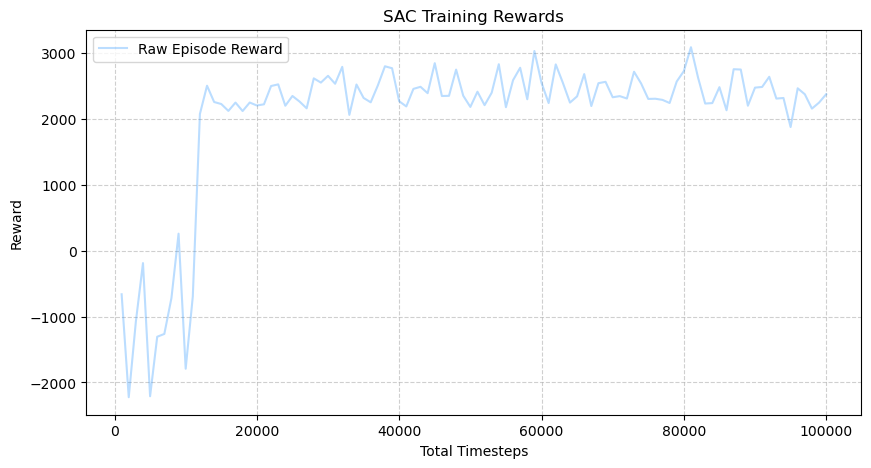

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_learning_curve(log_folder, title="SAC Training Rewards"):
    # Load the results from the monitor file
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards in light blue
    plt.plot(x, y, alpha=0.3, color='dodgerblue', label="Raw Episode Reward")
    
    # # Calculate and plot smoothed rewards
    # if len(y) > 50:
    #     # Convert to numpy array with .values to avoid the ValueError
    #     y_smoothed = pd.Series(y).rolling(window=50).mean().values
    #     plt.plot(x, y_smoothed, color='blue', linewidth=2, label="Rolling Mean (50 ep)")
    
    plt.xlabel('Total Timesteps')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the plotting function
plot_learning_curve("./sac_asv_logs_new/")

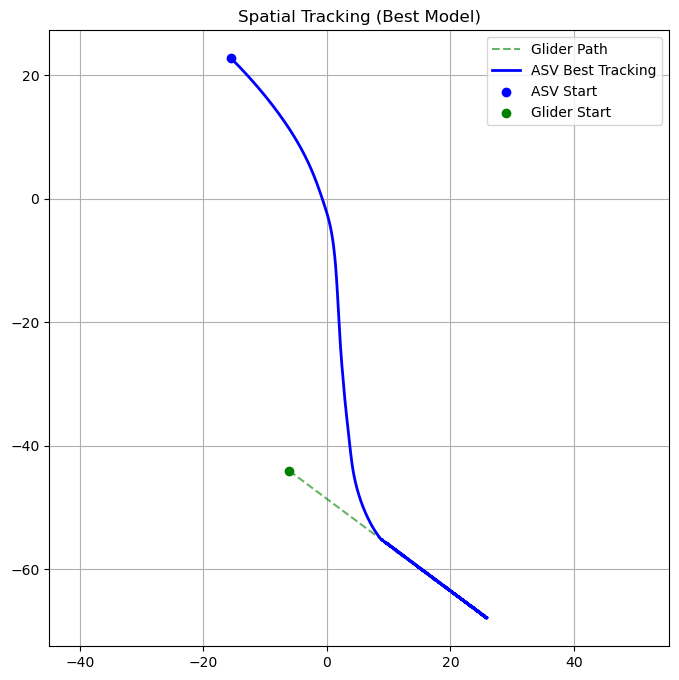

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
import os

# 1. Path to the best model
# Note: Adjust 'logs' to match the folder name you used in the EvalCallback
model_path = "./logs_sac/best_model/best_model.zip"

if not os.path.exists(model_path):
    print(f"Error: Could not find the best model at {model_path}")
else:
    # 2. Load the best model
    model = SAC.load(model_path)
    env = AsvGliderBearingEnv()
    obs, _ = env.reset()

    asv_path, glider_path, rewards = [], [], []
    done = False

    # 3. Run a test episode
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        asv_path.append(env.asv_pos.copy())
        glider_path.append(env.glider_pos.copy())
        rewards.append(reward)
        done = terminated or truncated

    asv_path, glider_path = np.array(asv_path), np.array(glider_path)

    # 4. Plot the Map
    plt.figure(figsize=(8, 8))
    plt.plot(glider_path[:, 0], glider_path[:, 1], 'g--', label="Glider Path", alpha=0.6)
    plt.plot(asv_path[:, 0], asv_path[:, 1], 'b-', label="ASV Best Tracking", linewidth=2)
    plt.scatter(asv_path[0,0], asv_path[0,1], c='blue', label="ASV Start")
    plt.scatter(glider_path[0,0], glider_path[0,1], c='green', label="Glider Start")
    plt.title("Spatial Tracking (Best Model)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()